In [1]:
#Victory Okezie Q1097004. Analysing Healthcare Big Data To build an end-to-end Big Data pipeline using Apache Spark and Hive, for predicting bone age from healthcare data using machine learning.
from pyspark.sql import SparkSession

# Start Spark with Hive support
spark = SparkSession.builder \
    .appName("BoneAgePrediction") \
    .enableHiveSupport() \
    .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/25 09:13:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
#I oragnised the database
spark.sql("CREATE DATABASE IF NOT EXISTS boneage_db")
spark.sql("USE boneage_db")

# Check current database
spark.sql("SELECT current_database()").show()


25/05/25 09:13:41 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
25/05/25 09:13:41 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore jovyan@172.19.0.4


+----------------+
|current_schema()|
+----------------+
|      boneage_db|
+----------------+



In [3]:
# Loading the training data
train_df = spark.read.csv("/home/jovyan/work/boneage-training-dataset.csv", header=True, inferSchema=True)

# Load test data
test_df = spark.read.csv("/home/jovyan/work/boneage-test-dataset.csv", header=True, inferSchema=True)

# Preview
train_df.show(5)
train_df.printSchema()


+----+-------+-----+
|  id|boneage| male|
+----+-------+-----+
|1377|    180|false|
|1378|     12|false|
|1379|     94|false|
|1380|    120| true|
|1381|     82|false|
+----+-------+-----+
only showing top 5 rows
root
 |-- id: integer (nullable = true)
 |-- boneage: integer (nullable = true)
 |-- male: boolean (nullable = true)



In [4]:
from pyspark.sql.functions import when, col
#Time For cleaning
# Drop rows with nulls
train_df = train_df.dropna()

# Convert 'male' to integer (true → 1, false → 0)
train_df = train_df.withColumn("male_int", when(col("male") == "true", 1).otherwise(0))

# Check cleaned data
train_df.select("id", "male", "male_int", "boneage").show(5)


+----+-----+--------+-------+
|  id| male|male_int|boneage|
+----+-----+--------+-------+
|1377|false|       0|    180|
|1378|false|       0|     12|
|1379|false|       0|     94|
|1380| true|       1|    120|
|1381|false|       0|     82|
+----+-----+--------+-------+
only showing top 5 rows


In [7]:
#for the feature engineering , i imported vector assembler this is good for machine learning
from pyspark.ml.feature import VectorAssembler

# i prepare features for ML
assembler = VectorAssembler(inputCols=["male_int"], outputCol="features")
final_train_df = assembler.transform(train_df).select("features", "boneage")


In [9]:
# i choose linear regression
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="boneage")

# Train the model
model = lr.fit(final_train_df)

print("Coefficients:", model.coefficients)
print("Intercept:", model.intercept)


25/05/25 09:16:28 WARN Instrumentation: [4f3c7a16] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [17.423437974357043]
Intercept: 117.88023537556246


In [10]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(final_train_df)

predictions.select("prediction", "boneage").show(5)

# Evaluate using RMSE
evaluator = RegressionEvaluator(labelCol="boneage", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("RMSE:", rmse)


+------------------+-------+
|        prediction|boneage|
+------------------+-------+
|117.88023537556246|    180|
|117.88023537556246|     12|
|117.88023537556246|     94|
| 135.3036733499195|    120|
|117.88023537556246|     82|
+------------------+-------+
only showing top 5 rows
RMSE: 40.25495624041058


In [11]:
# Rename columns to match training set
test_df = test_df.withColumnRenamed("Sex", "male") \
                 .withColumnRenamed("Case ID", "id")


In [12]:
# Clean test data
test_df = test_df.dropna()

# Convert male to integer (true → 1, false → 0)
test_df = test_df.withColumn("male_int", when(col("male") == "true", 1).otherwise(0))

# Assemble features
final_test_df = assembler.transform(test_df)

# Predict
test_predictions = model.transform(final_test_df)
test_predictions.select("id", "prediction").show(10)


+----+------------------+
|  id|        prediction|
+----+------------------+
|4360|117.88023537556246|
|4361|117.88023537556246|
|4362|117.88023537556246|
|4363|117.88023537556246|
|4364|117.88023537556246|
|4365|117.88023537556246|
|4366|117.88023537556246|
|4367|117.88023537556246|
|4368|117.88023537556246|
|4369|117.88023537556246|
+----+------------------+
only showing top 10 rows


In [13]:
# I Re-select the Hive database (in case my kernel restarted)
spark.sql("CREATE DATABASE IF NOT EXISTS boneage_db")
spark.sql("USE boneage_db")


DataFrame[]

In [14]:
# Save cleaned training data into Hive table
train_df.write.mode("overwrite").saveAsTable("boneage_train")


25/05/25 09:17:32 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
25/05/25 09:17:32 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist


In [15]:
# List all tables in current Hive database
spark.sql("SHOW TABLES").show()


+----------+-------------------+-----------+
| namespace|          tableName|isTemporary|
+----------+-------------------+-----------+
|boneage_db|boneage_predictions|      false|
|boneage_db|      boneage_train|      false|
+----------+-------------------+-----------+



In [16]:
#rows from the Hive table
spark.sql("SELECT * FROM boneage_train LIMIT 5").show()


+----+-------+-----+--------+
|  id|boneage| male|male_int|
+----+-------+-----+--------+
|1377|    180|false|       0|
|1378|     12|false|       0|
|1379|     94|false|       0|
|1380|    120| true|       1|
|1381|     82|false|       0|
+----+-------+-----+--------+



In [17]:

spark.sql("USE boneage_db")

# Save prediction output to Hive table
test_predictions.select("id", "prediction") \
    .write.mode("overwrite").saveAsTable("boneage_predictions")


In [18]:
# List tables
spark.sql("SHOW TABLES").show()

# Check predictions
spark.sql("SELECT * FROM boneage_predictions LIMIT 5").show()


+----------+-------------------+-----------+
| namespace|          tableName|isTemporary|
+----------+-------------------+-----------+
|boneage_db|boneage_predictions|      false|
|boneage_db|      boneage_train|      false|
+----------+-------------------+-----------+

+----+------------------+
|  id|        prediction|
+----+------------------+
|4360|117.88023537556246|
|4361|117.88023537556246|
|4362|117.88023537556246|
|4363|117.88023537556246|
|4364|117.88023537556246|
+----+------------------+



In [19]:
# Collect predictions to Pandas
pandas_df = predictions.select("boneage", "prediction").toPandas()
pandas_df.head()


,boneage,prediction
0,180,117.880235
1,12,117.880235
2,94,117.880235
3,120,135.303673
4,82,117.880235


In [21]:
#time for visualiztion to see our prediction
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: better style
sns.set(style="whitegrid")


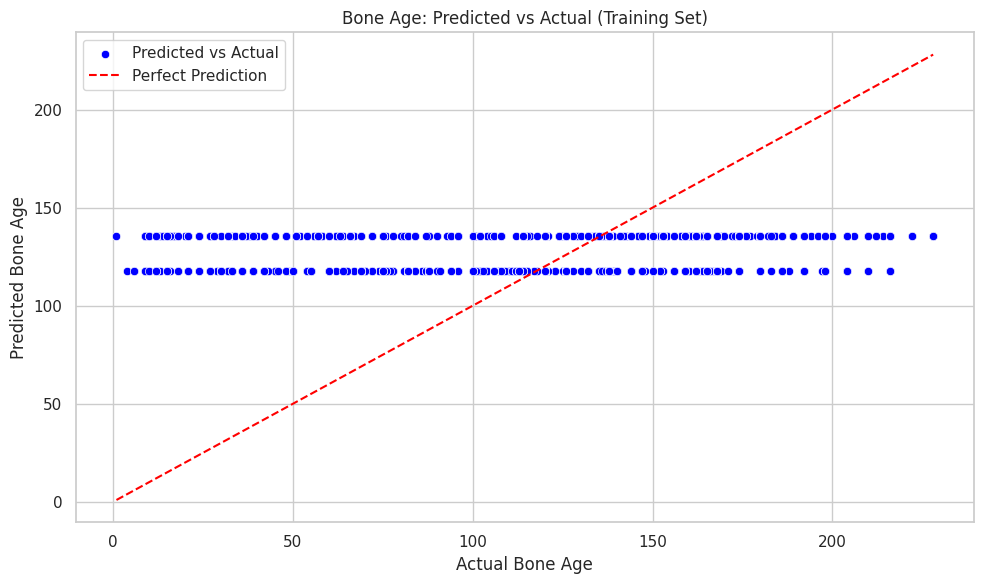

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x="boneage", y="prediction", color="blue", label="Predicted vs Actual")

# (perfect prediction line)
plt.plot([pandas_df.boneage.min(), pandas_df.boneage.max()],
         [pandas_df.boneage.min(), pandas_df.boneage.max()],
         color='red', linestyle='--', label='Perfect Prediction')

plt.title("Bone Age: Predicted vs Actual (Training Set)")
plt.xlabel("Actual Bone Age")
plt.ylabel("Predicted Bone Age")
plt.legend()
plt.tight_layout()
plt.show()


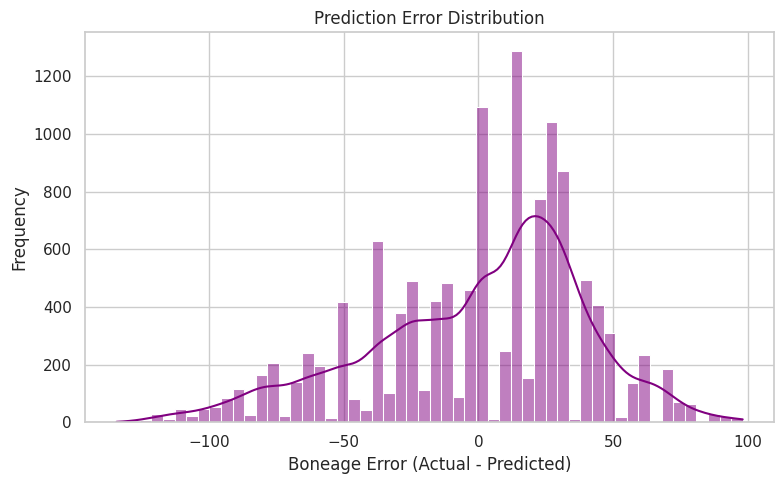

In [23]:

pandas_df["error"] = pandas_df["boneage"] - pandas_df["prediction"]

plt.figure(figsize=(8, 5))
sns.histplot(pandas_df["error"], kde=True, color="purple")
plt.title("Prediction Error Distribution")
plt.xlabel("Boneage Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [24]:
predictions = model.transform(final_train_df)


In [25]:
from pyspark.ml.evaluation import RegressionEvaluator

# Root Mean Squared Error
rmse_evaluator = RegressionEvaluator(
    labelCol="boneage", predictionCol="prediction", metricName="rmse"
)
rmse = rmse_evaluator.evaluate(predictions)

# Mean Absolute Error
mae_evaluator = RegressionEvaluator(
    labelCol="boneage", predictionCol="prediction", metricName="mae"
)
mae = mae_evaluator.evaluate(predictions)

# R² Score
r2_evaluator = RegressionEvaluator(
    labelCol="boneage", predictionCol="prediction", metricName="r2"
)
r2 = r2_evaluator.evaluate(predictions)

# Show all metrics
print(" Linear Regression Evaluation Metrics")
print(f" RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f" MAE  (Mean Absolute Error):     {mae:.2f}")
print(f" R²   (R-squared):               {r2:.4f}")


 Linear Regression Evaluation Metrics
 RMSE (Root Mean Squared Error): 40.25
 MAE  (Mean Absolute Error):     32.29
 R²   (R-squared):               0.0444


In [29]:
#stop the Spark session
spark.stop()

#'The detailed explanation of the result of the prediction and the model can be found in my essay' #Future refrence victoryokezie2003@gmail.com
